<a href="https://colab.research.google.com/github/zey-o/DeepLearning_Wikiart_Emotions/blob/main/5_binary_happiness_surprise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

import pathlib
import matplotlib.pyplot as plt

from glob import glob
import os 

# import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Activation

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer

## Check & Load Data from Directory

In [4]:
dir = 'drive/MyDrive/DL/dataset_images' 

In [5]:
data_dir = pathlib.Path("drive/MyDrive/DL/dataset_images")

In [6]:
image_count = len(list(data_dir.glob('**/*.png')))
print(image_count)

4119


In [7]:
df = pd.read_csv("drive/MyDrive/DL/path_prob.csv")

In [8]:
df.head(3)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,happiness,dataset_images/58c6237dedc2c9c7dc0de1ae.png
1,1,577280dfedc2cb3880f28e76,anticipation,dataset_images/577280dfedc2cb3880f28e76.png
2,2,57727f2dedc2cb3880ed5fa9,happiness,dataset_images/57727f2dedc2cb3880ed5fa9.png


In [9]:
df.path = "drive/MyDrive/DL/" + df.path
df.head(3)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,happiness,drive/MyDrive/DL/dataset_images/58c6237dedc2c9...
1,1,577280dfedc2cb3880f28e76,anticipation,drive/MyDrive/DL/dataset_images/577280dfedc2cb...
2,2,57727f2dedc2cb3880ed5fa9,happiness,drive/MyDrive/DL/dataset_images/57727f2dedc2cb...


In [10]:
df.emotion.value_counts()

happiness           1102
surprise             822
anticipation         520
trust                478
fear                 358
sadness              226
humility             184
love                 114
disgust              101
optimism              62
arrogance             52
anger                 36
gratitude             14
pessimism             10
disagreeableness       7
shame                  7
neutral                5
agreeableness          5
shyness                2
Name: emotion, dtype: int64

For our binary problem, we will go ahead with the top two emotions: "happiness" and "suprise"

In [11]:
df = df[(df.emotion == "happiness") | (df.emotion == "surprise")]
df.head(2)

,Unnamed: 0,ID,emotion,path
0,0,58c6237dedc2c9c7dc0de1ae,happiness,drive/MyDrive/DL/dataset_images/58c6237dedc2c9...
2,2,57727f2dedc2cb3880ed5fa9,happiness,drive/MyDrive/DL/dataset_images/57727f2dedc2cb...


In [ ]:
df.emotion.value_counts()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1924 entries, 0 to 4104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1924 non-null   int64 
 1   ID          1924 non-null   object
 2   emotion     1924 non-null   object
 3   path        1924 non-null   object
dtypes: int64(1), object(3)
memory usage: 75.2+ KB


In [13]:
image_count = len(df)
image_count

1924

## Modeling 

We will first set the parameters that we will be using throughout the modeling process and then run the following models: 
1. Baseline 
2. Using Convolutions
3. Data Augmentation (with the Convolutions) 
4. A second way of Data Augmentation (implemented with Convolutions) 
5. Transfer Learning 
6. Transfer Learning with Data Augmentation 
7. Transfer Learning with Data Augmentation Getting Rid of Dense Layers but adding more Dropouts as well as regularization in the Layers
8. Another try 
9. Try VGG16 structure
10. FINAL MODEL

### Set parameters

Let's set some of the parameters we will be using. 

- The image size we will resize all images to at the beginning of our training process. 
- We will set the number of epochs to a certain number so that we can keep tweaking it later. 
- Batch size will be 32. 
- The emotions we will be working with. 
- We will split the data into 3: train - validation - test (60% - 20% - 20%) 

In [14]:
img_height = 180
img_width = 180

In [15]:
epochs = 100
batch_size = 32

In [16]:
val_set_start = int((6)*image_count//10)
test_set_start = int(8*image_count//10)

In [17]:
test_set_start

1539

In [18]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            # # interpolation = 'bilinear',
                                            # seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [45]:
class_names = train_generator.class_indices
print(class_names)

{'happiness': 0, 'surprise': 1}


In [20]:
images, labels = next(train_generator)
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 180, 180, 3)
float32 (32,)


In [21]:
num_classes = len(class_names)
num_classes

2

In [22]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


### 1. Baseline

We will make three generators according to the above split. 

The number of classes will be the number of emotions examined. We know from our EDA that there is a class imbalance between the classses but as we are doing multi-labels we will go with this for now. 

We will then make a baseline model with 20 nodes and plot to see how train & validation accuracy and losses change over epochs. 

In [ ]:
model = Sequential([
    keras.layers.InputLayer(input_shape=(img_height, img_width,3)),
    keras.layers.Dense(units = 20, activation = 'relu'), 
    keras.layers.Flatten(),
    keras.layers.Dense(units = 1, activation = 'sigmoid') 
])

In [ ]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 180, 180, 20)      80        
                                                                 
 flatten_1 (Flatten)         (None, 648000)            0         
                                                                 
 dense_3 (Dense)             (None, 1)                 648001    
                                                                 
Total params: 648,081
Trainable params: 648,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_baseline = model.fit(train_generator,
                    # steps_per_epoch=STEP_SIZE_TRAIN,
                    steps_per_epoch = 25, 
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
25/25 [==============================] - 264s 11s/step - loss: 2.5745 - accuracy: 0.6377 - val_loss: 1.7769 - val_accuracy: 0.6042
Epoch 2/100
25/25 [==============================] - 63s 3s/step - loss: 1.4163 - accuracy: 0.6571 - val_loss: 1.4965 - val_accuracy: 0.6406
Epoch 3/100
25/25 [==============================] - 35s 1s/step - loss: 0.9994 - accuracy: 0.7000 - val_loss: 1.0324 - val_accuracy: 0.6536
Epoch 4/100
25/25 [==============================] - 29s 1s/step - loss: 0.8160 - accuracy: 0.7260 - val_loss: 0.9741 - val_accuracy: 0.6536
Epoch 5/100
25/25 [==============================] - 25s 989ms/step - loss: 1.1072 - accuracy: 0.6844 - val_loss: 1.1299 - val_accuracy: 0.6536
Epoch 6/100
25/25 [==============================] - 26s 1s/step - loss: 1.1278 - accuracy: 0.7286 - val_loss: 1.2815 - val_accuracy: 0.6562
Epoch 7/100
25/25 [==============================] - 26s 1s/step - loss: 0.7000 - accuracy: 0.7588 - val_loss: 1.1651 - val_accuracy: 0.6562
Epoch 8/

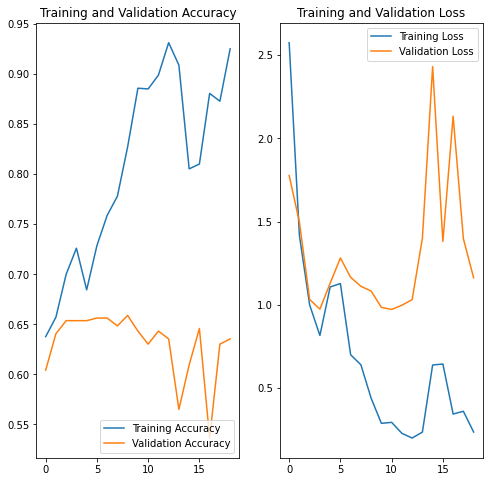

In [ ]:
number_of_epochs_it_ran = len(history_baseline.history['loss'])

acc = history_baseline.history['accuracy']
val_acc = history_baseline.history['val_accuracy']

loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2. Using Convolutions

Let's first try making our own convolutions. 

In [ ]:
model = Sequential()


model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                      

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history_cnn = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
36/36 [==============================] - 41s 942ms/step - loss: 1.0723 - accuracy: 0.5677 - val_loss: 0.6873 - val_accuracy: 0.6302
Epoch 2/100
36/36 [==============================] - 33s 919ms/step - loss: 0.6815 - accuracy: 0.5989 - val_loss: 0.6840 - val_accuracy: 0.5885
Epoch 3/100
36/36 [==============================] - 33s 931ms/step - loss: 0.6873 - accuracy: 0.5722 - val_loss: 0.6821 - val_accuracy: 0.5807
Epoch 4/100
36/36 [==============================] - 33s 931ms/step - loss: 0.6803 - accuracy: 0.5802 - val_loss: 0.6727 - val_accuracy: 0.6849
Epoch 5/100
36/36 [==============================] - 32s 905ms/step - loss: 0.6552 - accuracy: 0.6586 - val_loss: 0.6365 - val_accuracy: 0.6745
Epoch 6/100
36/36 [==============================] - 33s 933ms/step - loss: 0.6180 - accuracy: 0.6970 - val_loss: 0.6243 - val_accuracy: 0.6615
Epoch 7/100
36/36 [==============================] - 33s 937ms/step - loss: 0.5554 - accuracy: 0.7317 - val_loss: 0.6706 - val_accuracy:

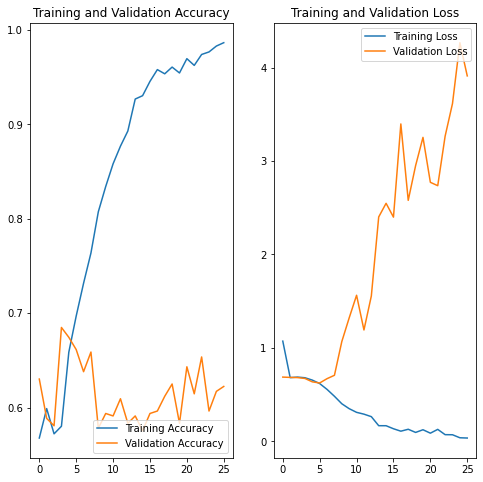

In [ ]:
number_of_epochs_it_ran = len(history_cnn.history['loss'])

acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. Data Augmentation

Now let's try the same convolutions we looked at but do it with augmented data. 

In [ ]:
train_generator.reset()
valid_generator.reset()
test_generator.reset()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
    data_augmentation, 
    layers.Conv2D(32, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    
    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 

    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 

    layers.Conv2D(64, (3, 3), padding='same', activation = 'relu'), 
    layers.MaxPooling2D(pool_size=(2, 2)), 
    layers.Dropout(0.25), 
    layers.Flatten(),
    layers.Dense(512, activation = 'relu'), 
    layers.Dropout(0.5), 
    layers.Dense(1, activation='sigmoid')])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 45, 45, 64)       

In [ ]:
history_aug = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
36/36 [==============================] - 35s 953ms/step - loss: 0.6960 - accuracy: 0.5579 - val_loss: 0.6630 - val_accuracy: 0.6068
Epoch 2/100
36/36 [==============================] - 33s 915ms/step - loss: 0.6501 - accuracy: 0.6230 - val_loss: 0.6841 - val_accuracy: 0.5443
Epoch 3/100
36/36 [==============================] - 33s 932ms/step - loss: 0.6042 - accuracy: 0.6747 - val_loss: 0.6494 - val_accuracy: 0.6146
Epoch 4/100
36/36 [==============================] - 33s 921ms/step - loss: 0.6054 - accuracy: 0.6818 - val_loss: 0.6201 - val_accuracy: 0.6615
Epoch 5/100
36/36 [==============================] - 33s 919ms/step - loss: 0.5900 - accuracy: 0.6827 - val_loss: 0.6341 - val_accuracy: 0.6276
Epoch 6/100
36/36 [==============================] - 33s 912ms/step - loss: 0.5902 - accuracy: 0.6925 - val_loss: 0.6148 - val_accuracy: 0.6562
Epoch 7/100
36/36 [==============================] - 33s 916ms/step - loss: 0.6033 - accuracy: 0.6845 - val_loss: 0.6295 - val_accuracy:

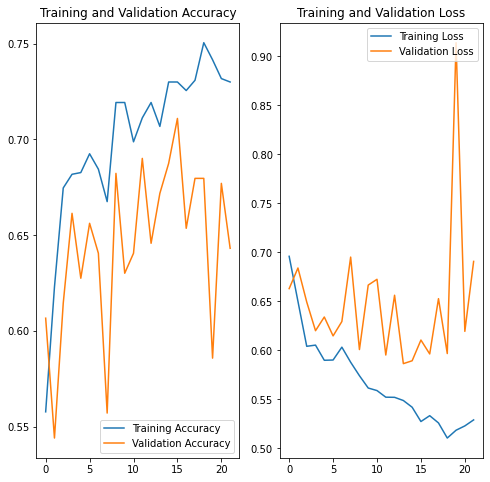

In [ ]:
number_of_epochs_it_ran = len(history_aug.history['loss'])

acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4. Second Way: Data Augmentation

A second way of data augmentation. Data augmentation is important as we are overfitting badly so we have to figure out ways to deal with this. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',    
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(img_height, img_width,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 88, 88, 32)        9248      
                                                                 
 activation_6 (Activation)   (None, 88, 88, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 44, 44, 32)       0         
 g2D)                                                 

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
history_aug2 = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs, 
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)

)

Epoch 1/100
36/36 [==============================] - 42s 1s/step - loss: 0.7033 - accuracy: 0.5642 - val_loss: 0.6875 - val_accuracy: 0.5833
Epoch 2/100
36/36 [==============================] - 41s 1s/step - loss: 0.6794 - accuracy: 0.5749 - val_loss: 0.6622 - val_accuracy: 0.5781
Epoch 3/100
36/36 [==============================] - 41s 1s/step - loss: 0.6399 - accuracy: 0.6399 - val_loss: 0.6302 - val_accuracy: 0.6198
Epoch 4/100
36/36 [==============================] - 42s 1s/step - loss: 0.6303 - accuracy: 0.6450 - val_loss: 0.6225 - val_accuracy: 0.6172
Epoch 5/100
36/36 [==============================] - 40s 1s/step - loss: 0.6187 - accuracy: 0.6542 - val_loss: 0.6261 - val_accuracy: 0.6589
Epoch 6/100
36/36 [==============================] - 41s 1s/step - loss: 0.6127 - accuracy: 0.6649 - val_loss: 0.6059 - val_accuracy: 0.6589
Epoch 7/100
36/36 [==============================] - 41s 1s/step - loss: 0.6029 - accuracy: 0.6720 - val_loss: 0.5943 - val_accuracy: 0.6641
Epoch 8/100
3

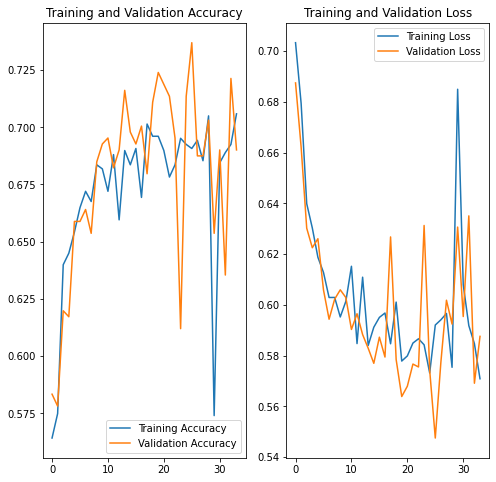

In [ ]:
number_of_epochs_it_ran = len(history_aug2.history['loss'])

acc = history_aug2.history['accuracy']
val_acc = history_aug2.history['val_accuracy']

loss = history_aug2.history['loss']
val_loss = history_aug2.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 5. Transfer Learning w/ MobileNet

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
history_transfer = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
36/36 [==============================] - 39s 1s/step - loss: 2.3941 - accuracy: 0.7148 - val_loss: 1.7698 - val_accuracy: 0.6536
Epoch 2/100
36/36 [==============================] - 35s 988ms/step - loss: 0.4422 - accuracy: 0.8886 - val_loss: 0.9006 - val_accuracy: 0.8464
Epoch 3/100
36/36 [==============================] - 35s 977ms/step - loss: 0.5171 - accuracy: 0.9020 - val_loss: 1.2294 - val_accuracy: 0.8516
Epoch 4/100
36/36 [==============================] - 35s 967ms/step - loss: 0.1998 - accuracy: 0.9394 - val_loss: 1.3308 - val_accuracy: 0.8698
Epoch 5/100
36/36 [==============================] - 34s 955ms/step - loss: 0.1371 - accuracy: 0.9617 - val_loss: 1.4255 - val_accuracy: 0.7786
Epoch 6/100
36/36 [==============================] - 35s 975ms/step - loss: 0.0421 - accuracy: 0.9848 - val_loss: 1.3145 - val_accuracy: 0.8542
Epoch 7/100
36/36 [==============================] - 35s 990ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 1.1176 - val_accuracy: 0.

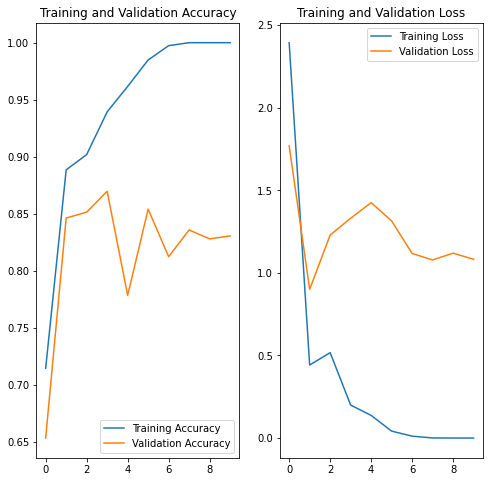

In [ ]:
number_of_epochs_it_ran = len(history_transfer.history['loss'])

acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6. Transfer Learning w/ MobileNet w/ Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


In [ ]:
x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
history_transfer_aug = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
36/36 [==============================] - 45s 1s/step - loss: 2.3751 - accuracy: 0.7148 - val_loss: 0.8983 - val_accuracy: 0.7656
Epoch 2/100
36/36 [==============================] - 41s 1s/step - loss: 0.9660 - accuracy: 0.7504 - val_loss: 1.0278 - val_accuracy: 0.7969
Epoch 3/100
36/36 [==============================] - 42s 1s/step - loss: 0.8803 - accuracy: 0.7852 - val_loss: 0.7535 - val_accuracy: 0.7995
Epoch 4/100
36/36 [==============================] - 41s 1s/step - loss: 0.5193 - accuracy: 0.8422 - val_loss: 0.7114 - val_accuracy: 0.8125
Epoch 5/100
36/36 [==============================] - 41s 1s/step - loss: 0.4780 - accuracy: 0.8342 - val_loss: 0.6955 - val_accuracy: 0.7969
Epoch 6/100
36/36 [==============================] - 41s 1s/step - loss: 0.4622 - accuracy: 0.8422 - val_loss: 0.6673 - val_accuracy: 0.7917
Epoch 7/100
36/36 [==============================] - 41s 1s/step - loss: 0.5525 - accuracy: 0.7620 - val_loss: 0.5081 - val_accuracy: 0.6927
Epoch 8/100
3

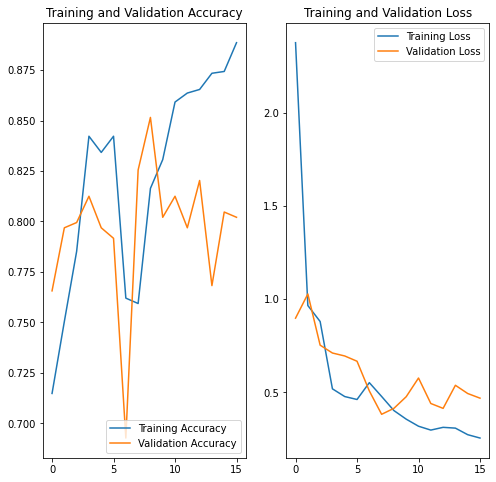

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug.history['loss'])

acc = history_transfer_aug.history['accuracy']
val_acc = history_transfer_aug.history['val_accuracy']

loss = history_transfer_aug.history['loss']
val_loss = history_transfer_aug.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 7. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization

Make it less complex and try more dropouts. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


In [ ]:
L2 = 50
DROP = 0.3

x = base_model.output
x = Flatten()(x) 
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
predictions = Dense(1, activation='sigmoid')(x) 


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True))

history_transfer_aug_drop = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = [es, lr]
)


# TAKING OUT THE FOLLOWING FROM LAST MODEL IN EARLYSTOPPING: 
# monitor='val_loss', mode='min', 

Epoch 1/100
36/36 [==============================] - 45s 1s/step - loss: 2655.6443 - accuracy: 0.6043 - val_loss: 1628.4489 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 2/100
36/36 [==============================] - 41s 1s/step - loss: 1273.6158 - accuracy: 0.6061 - val_loss: 978.1052 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
36/36 [==============================] - 41s 1s/step - loss: 774.8893 - accuracy: 0.6373 - val_loss: 586.9271 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 4/100
36/36 [==============================] - 41s 1s/step - loss: 460.6215 - accuracy: 0.6105 - val_loss: 343.3418 - val_accuracy: 0.6849 - lr: 0.0010
Epoch 5/100
36/36 [==============================] - 41s 1s/step - loss: 265.6604 - accuracy: 0.5633 - val_loss: 194.9343 - val_accuracy: 0.5807 - lr: 0.0010
Epoch 6/100
36/36 [==============================] - 41s 1s/step - loss: 148.4823 - accuracy: 0.5963 - val_loss: 107.3827 - val_accuracy: 0.5807 - lr: 0.0010
Epoch 7/100
36/36 [==============================

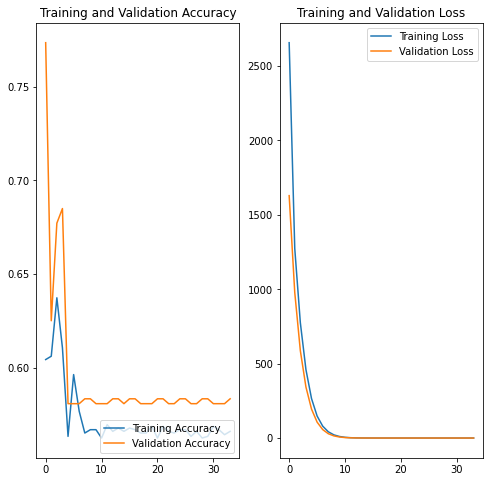

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug_drop.history['loss'])

acc = history_transfer_aug_drop.history['accuracy']
val_acc = history_transfer_aug_drop.history['val_accuracy']

loss = history_transfer_aug_drop.history['loss']
val_loss = history_transfer_aug_drop.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 8. Transfer Learning + Data Augmentation + Less Complex with more Dropouts + Regularization


Make it less complex and try more dropouts. 

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [ ]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

In [ ]:
L2 = 50
DROP = 0.3

x = base_model.output
x = Flatten()(x) 
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
x = Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(300, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x)
x = Dropout(DROP)(x)
x = Dense(50, activation='relu', kernel_regularizer=keras.regularizers.l2(L2))(x) 
x = Dropout(DROP)(x)
predictions = Dense(1, activation='sigmoid')(x) 


model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']         

In [ ]:
# lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True))

history_transfer_aug_drop = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = es
                    # callbacks = [es, lr]
)


# TAKING OUT THE FOLLOWING FROM LAST MODEL IN EARLYSTOPPING: 
# monitor='val_loss', mode='min', 

Epoch 1/100
36/36 [==============================] - 45s 1s/step - loss: 15882.4453 - accuracy: 0.5668 - val_loss: 9098.7842 - val_accuracy: 0.5807
Epoch 2/100
36/36 [==============================] - 41s 1s/step - loss: 5848.3247 - accuracy: 0.5668 - val_loss: 3415.2576 - val_accuracy: 0.5807
Epoch 3/100
36/36 [==============================] - 41s 1s/step - loss: 2199.9534 - accuracy: 0.5686 - val_loss: 1310.0627 - val_accuracy: 0.5807
Epoch 4/100
36/36 [==============================] - 41s 1s/step - loss: 876.2234 - accuracy: 0.5668 - val_loss: 537.6015 - val_accuracy: 0.5807
Epoch 5/100
36/36 [==============================] - 40s 1s/step - loss: 372.2079 - accuracy: 0.5704 - val_loss: 240.0739 - val_accuracy: 0.5807
Epoch 6/100
36/36 [==============================] - 41s 1s/step - loss: 171.4510 - accuracy: 0.5642 - val_loss: 114.2665 - val_accuracy: 0.5807
Epoch 7/100
36/36 [==============================] - 41s 1s/step - loss: 81.6832 - accuracy: 0.5677 - val_loss: 56.1201 - v

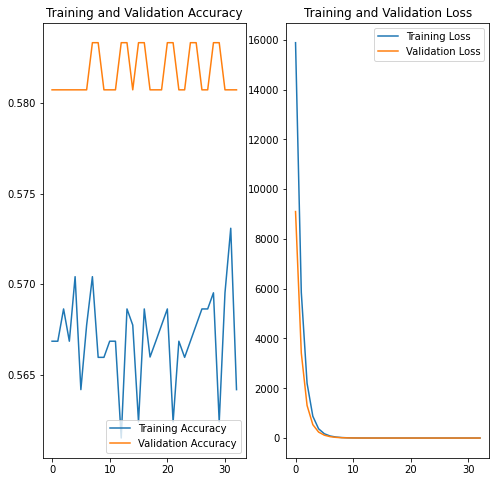

In [ ]:
number_of_epochs_it_ran = len(history_transfer_aug_drop.history['loss'])

acc = history_transfer_aug_drop.history['accuracy']
val_acc = history_transfer_aug_drop.history['val_accuracy']

loss = history_transfer_aug_drop.history['loss']
val_loss = history_transfer_aug_drop.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Try VGG16  

In [ ]:
L2 = 50
DROP = 0.3

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   

In [ ]:
model = Sequential(
                [InputLayer(input_shape= (img_height, img_width, 3)),
                 base_model,
                 Flatten(),
                 Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(L2)),
                 Dropout(DROP), 
                 Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(L2)),
                 Dropout(DROP), 
                 Dense(1, activation='sigmoid')]
               )

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#, run_eagerly=True

In [ ]:
lr = (ReduceLROnPlateau(factor=.5, patience=3, verbose=1))
es = (EarlyStopping(verbose=1, patience = 8, restore_best_weights=True, monitor='val_loss'))

In [ ]:
history_vgg_model = model.fit(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_generator,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = es)
                      # callbacks = [es, lr])

Epoch 1/100
36/36 [==============================] - 44s 1s/step - loss: 5510.3813 - accuracy: 0.5642 - val_loss: 2667.6667 - val_accuracy: 0.5807
Epoch 2/100
36/36 [==============================] - 41s 1s/step - loss: 1838.1656 - accuracy: 0.5633 - val_loss: 1221.8591 - val_accuracy: 0.5807
Epoch 3/100
36/36 [==============================] - 42s 1s/step - loss: 861.6373 - accuracy: 0.5651 - val_loss: 554.8293 - val_accuracy: 0.5807
Epoch 4/100
36/36 [==============================] - 41s 1s/step - loss: 381.0692 - accuracy: 0.5677 - val_loss: 237.6139 - val_accuracy: 0.5833
Epoch 5/100
36/36 [==============================] - 41s 1s/step - loss: 157.3967 - accuracy: 0.5695 - val_loss: 95.3444 - val_accuracy: 0.5807
Epoch 6/100
36/36 [==============================] - 41s 1s/step - loss: 61.8812 - accuracy: 0.5668 - val_loss: 35.8729 - val_accuracy: 0.5807
Epoch 7/100
36/36 [==============================] - 42s 1s/step - loss: 22.7825 - accuracy: 0.5677 - val_loss: 12.8198 - val_acc

In [ ]:
model.save('binary_hs_vgg16_model.h5')

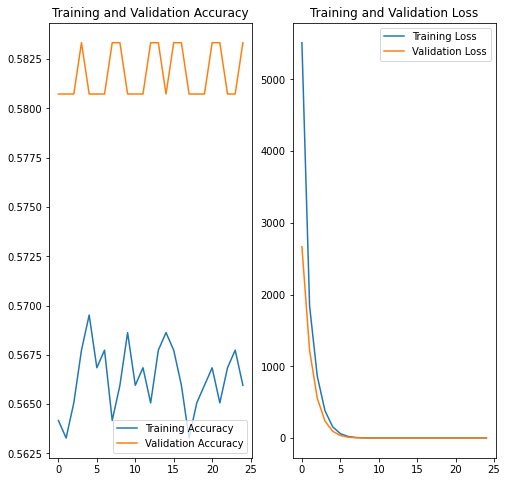

In [ ]:
number_of_epochs_it_ran = len(history_vgg_model.history['loss'])

acc = history_vgg_model.history['accuracy']
val_acc = history_vgg_model.history['val_accuracy']

loss = history_vgg_model.history['loss']
val_loss = history_vgg_model.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 10. FINAL MODEL 

Obviously, the best model so far seems to be a combination of using MobileNet architecture with ImageNet weights and then augmenting the data as well. Let's give this a try but also combine it with CNN's. 



In [23]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
                                        dataframe = df[:val_set_start],
                                        x_col = "path",
                                        y_col = "emotion",
                                        batch_size = 32,
                                        interpolation = 'bilinear',
                                        seed = 42,
                                        shuffle = True,
                                        class_mode = "binary",
                                        target_size = (img_height, img_width))

valid_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[(val_set_start):(test_set_start)],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

test_generator=test_datagen.flow_from_dataframe(
                                            dataframe = df[test_set_start:],
                                            x_col = "path",
                                            y_col = "emotion",
                                            batch_size = 32,
                                            interpolation = 'bilinear',
                                            seed = 42,
                                            shuffle = False,
                                            class_mode = "binary",
                                            target_size = (img_height, img_width))

Found 1154 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.
Found 385 validated image filenames belonging to 2 classes.


In [24]:
base_model = mobilenet_v2.MobileNetV2\
                (weights='imagenet', include_top=False, input_shape=(img_height, img_width,3)) 

for layer in base_model.layers:
    layer.trainable = False   


9420800/9406464 [==============================] - 0s 0us/step


In [25]:
x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) 

model_binary = Model(inputs=base_model.input, outputs=predictions)
model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_binary.summary()

# model_binary = Sequential(
#                 [InputLayer(input_shape= (img_height, img_width, 3)),
#                  base_model,
#                  Flatten(),
#                 #  Conv2D(32, (3,3), padding = 'same', activation = 'relu'), 
#                 #  MaxPool2D(),
#                 #  Conv2D(64, (3,3), padding = 'same', activation = 'relu'), 
#                 #  MaxPool2D(),  
#                 #  Dropout(0.25),                  
#                  Dense(512, activation='relu'),
#                  Dense(100, activation='relu'), 
#                  Dense(512, activation='relu'),
#                  Dense(100, activation='relu'),
#                  Dense(1, activation='sigmoid')]
# )




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][0]']           

In [26]:
history_binary = model_binary.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=epochs,
                    callbacks = EarlyStopping(monitor='val_loss', \
                                              mode='min', verbose=1, patience = 8,\
                                             restore_best_weights=True)
)

Epoch 1/100
36/36 [==============================] - 374s 10s/step - loss: 2.6709 - accuracy: 0.6898 - val_loss: 1.0515 - val_accuracy: 0.7812
Epoch 2/100
36/36 [==============================] - 45s 1s/step - loss: 1.0148 - accuracy: 0.7879 - val_loss: 1.1843 - val_accuracy: 0.7682
Epoch 3/100
36/36 [==============================] - 45s 1s/step - loss: 0.8975 - accuracy: 0.7897 - val_loss: 0.8944 - val_accuracy: 0.8151
Epoch 4/100
36/36 [==============================] - 45s 1s/step - loss: 0.7435 - accuracy: 0.8209 - val_loss: 0.8759 - val_accuracy: 0.7917
Epoch 5/100
36/36 [==============================] - 45s 1s/step - loss: 0.7053 - accuracy: 0.8200 - val_loss: 1.3135 - val_accuracy: 0.7500
Epoch 6/100
36/36 [==============================] - 45s 1s/step - loss: 0.8281 - accuracy: 0.8012 - val_loss: 0.9424 - val_accuracy: 0.8229
Epoch 7/100
36/36 [==============================] - 46s 1s/step - loss: 0.5207 - accuracy: 0.8520 - val_loss: 0.9349 - val_accuracy: 0.8151
Epoch 8/100

In [27]:
# from keras.models import load_model
MODEL_PATH = "drive/MyDrive/DL/model_hs_binary.h5"
model_binary.save(MODEL_PATH)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


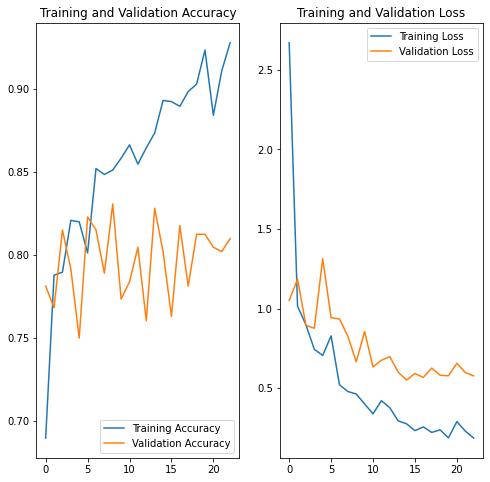

In [28]:
number_of_epochs_it_ran = len(history_binary.history['loss'])

acc = history_binary.history['accuracy']
val_acc = history_binary.history['val_accuracy']

loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(number_of_epochs_it_ran)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
from google.colab import files
#images_dir = '/content/gdrive/MyDrive/DL'
# plt.savefig("Happiness_Surprise_Binary_Model_Plots.png", bbox_inches='tight', dpi = 250)
# files.download("Happiness_Surprise_Binary_Model_Plots.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

## Predict & Evaluate

### Predict

In [ ]:
predictions = model_binary.predict(test_generator)

In [ ]:
predictions_mapped = [0 if pred <0.5 else 1 for pred in predictions]
y_ground_truth = test_generator.labels

In [ ]:
predicted_emotions = [class_names_list[k] for k in predictions_mapped]
print(predicted_emotions)

['surprise', 'happiness', 'happiness', 'happiness', 'surprise', 'surprise', 'surprise', 'happiness', 'surprise', 'surprise', 'happiness', 'happiness', 'happiness', 'happiness', 'happiness', 'surprise', 'happiness', 'happiness', 'surprise', 'happiness', 'surprise', 'happiness', 'happiness', 'happiness', 'happiness', 'happiness', 'surprise', 'surprise', 'surprise', 'happiness', 'surprise', 'surprise', 'happiness', 'happiness', 'surprise', 'happiness', 'surprise', 'surprise', 'happiness', 'happiness', 'surprise', 'surprise', 'happiness', 'surprise', 'surprise', 'surprise', 'surprise', 'surprise', 'surprise', 'happiness', 'happiness', 'happiness', 'happiness', 'happiness', 'happiness', 'happiness', 'happiness', 'happiness', 'surprise', 'surprise', 'happiness', 'happiness', 'surprise', 'happiness', 'surprise', 'happiness', 'happiness', 'surprise', 'happiness', 'surprise', 'happiness', 'surprise', 'happiness', 'surprise', 'happiness', 'happiness', 'happiness', 'surprise', 'happiness', 'surpr

### Evaluate

In [ ]:
model_binary.evaluate(test_generator)

13/13 [==============================] - 11s 799ms/step - loss: 0.5563 - accuracy: 0.8052


[0.55629563331604, 0.8051947951316833]

In [ ]:
confusion = confusion_matrix(y_ground_truth, predictions_mapped)
confusion

array([[136,  88],
       [ 93,  68]])

Text(0.5, 1.0, 'Confusion Matrix')

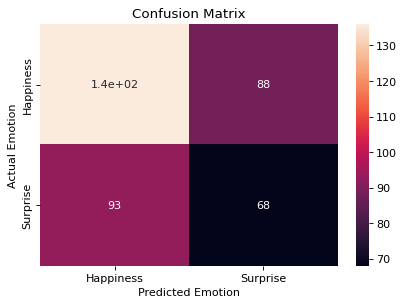

In [ ]:
plt.figure(dpi=80)
sns.heatmap(confusion, annot=True, \
            xticklabels=['Happiness', 'Surprise'], yticklabels=['Happiness', 'Surprise'])
cmlabels = ['True Negatives', "False Positives",
               'Flase Negatives', "True Positives"]
plt.xlabel('Predicted Emotion')
plt.ylabel('Actual Emotion')
plt.title('Confusion Matrix')
# plt.savefig("Confusion Matrix for Binary.png", bbox_inches='tight');
# files.download("Confusion Matrix for Binary.png") 

In [ ]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_ground_truth, predictions_mapped)

In [ ]:
print(classification_report(y_ground_truth, predictions_mapped))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       224
           1       0.44      0.42      0.43       161

    accuracy                           0.53       385
   macro avg       0.51      0.51      0.51       385
weighted avg       0.53      0.53      0.53       385



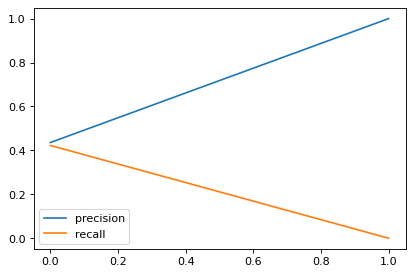

In [ ]:
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
# plt.xlabel('Threshold (above this probability, label as highlight-possible)');
# plt.title('Precision and Recall Curves for Modern Met')
# plt.savefig("Precision and Recall Curves for Modern Met.png", bbox_inches='tight');

ROC AUC score =  0.5


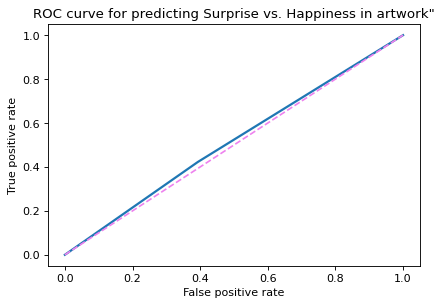

In [ ]:
fpr, tpr, thresholds = roc_curve(y_ground_truth, predictions_mapped)
plt.figure(dpi=80)

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for predicting Surprise vs. Happiness in artwork"')
# plt.savefig("ROC curve for predicting Surprise vs. Happiness in emotion.png", bbox_inches='tight')
# files.download("ROC curve for predicting Surprise vs. Happiness in emotion.png") 
print("ROC AUC score = ", roc_auc_score(y_ground_truth, predicted_class_indices))

### Testing an image

Test an image for detection of emotion

In [ ]:
orozco_path = "drive/MyDrive/DL/1024px-Orozco_Mural_Omniciencia_1925_Azulejos.jpg"

img = load_img(orozco_path, target_size=(img_height, img_width))
img_array = img_to_array(img)
img_array = expand_dims(img_array, 0) 

pred = model_binary.predict(img_array)
pred_mapped = (0 if pred <0.5 else 1)
predicted_emotion = class_names_list[pred_mapped]

accuracy = model_binary.evaluate(test_generator, verbose = 0)[1]
print("This image most likely evokes {} with a {:.2f} percent accuracy."
    .format(predicted_emotion, 100 * accuracy))

This image most likely evokes surprise with a 80.52 percent accuracy.


In [ ]:
def which_emotion(image_path): 
  img = load_img(image_path, target_size=(img_height, img_width))
  img_array = img_to_array(img)
  img_array = expand_dims(img_array, 0) 

  pred = model_binary.predict(img_array)
  pred_mapped = (0 if pred <0.5 else 1)
  predicted_emotion = class_names_list[pred_mapped]

  accuracy = model_binary.evaluate(test_generator, verbose = 0)[1]
  print("This image most likely evokes {} with a {:.2f} percent accuracy."
      .format(predicted_emotion, 100 * accuracy))

In [ ]:
which_emotion(orozco_path)

This image most likely evokes surprise with a 80.52 percent accuracy.


### Figure out Wrong Predictions

In [ ]:
path_names = test_generator.filenames
idx = test_generator.index_array

In [ ]:
predictions_dict = {"index": idx, "path_names": path_names, "actual_emotion": y_ground_truth, "predicted_emotion": predicted_emotions}
predictions_df = pd.DataFrame(predictions_dict)
predictions_df.head(3)

,index,path_names,actual_emotion,predicted_emotion
0,365,drive/MyDrive/DL/dataset_images/57727f6fedc2cb...,1,surprise
1,206,drive/MyDrive/DL/dataset_images/577286deedc2cb...,0,happiness
2,48,drive/MyDrive/DL/dataset_images/5772765aedc2cb...,0,happiness


In [ ]:
predictions_df.actual_emotion = predictions_df.actual_emotion.apply(lambda x: "happiness" if (x ==0) else "surprise" )
predictions_df.head(3)

,index,path_names,actual_emotion,predicted_emotion
0,365,drive/MyDrive/DL/dataset_images/57727f6fedc2cb...,surprise,surprise
1,206,drive/MyDrive/DL/dataset_images/577286deedc2cb...,happiness,happiness
2,48,drive/MyDrive/DL/dataset_images/5772765aedc2cb...,happiness,happiness


In [ ]:
wrong_predictions = (predictions_df[predictions_df.actual_emotion != predictions_df.predicted_emotion])
wrong_predictions

,index,path_names,actual_emotion,predicted_emotion
4,334,drive/MyDrive/DL/dataset_images/57728392edc2cb...,happiness,surprise
6,200,drive/MyDrive/DL/dataset_images/57728392edc2cb...,happiness,surprise
7,14,drive/MyDrive/DL/dataset_images/577277bbedc2cb...,surprise,happiness
8,349,drive/MyDrive/DL/dataset_images/57727287edc2cb...,happiness,surprise
9,284,drive/MyDrive/DL/dataset_images/57727e6fedc2cb...,happiness,surprise
...,...,...,...,...
374,9,drive/MyDrive/DL/dataset_images/577283d1edc2cb...,happiness,surprise
378,73,drive/MyDrive/DL/dataset_images/57728704edc2cb...,happiness,surprise
379,21,drive/MyDrive/DL/dataset_images/57726e32edc2cb...,happiness,surprise
380,94,drive/MyDrive/DL/dataset_images/57728752edc2cb...,surprise,happiness


Predicted: happiness. Got: surprise.


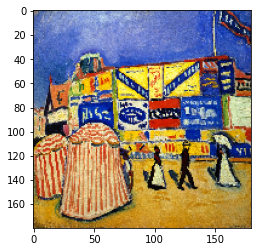

In [ ]:
img = load_img(wrong_predictions.iloc[0, 1], target_size=(img_height, img_width))
plt.imshow(img)
print(f"Predicted: {wrong_predictions.iloc[0, 2]}. Got: {wrong_predictions.iloc[0, 3]}.")

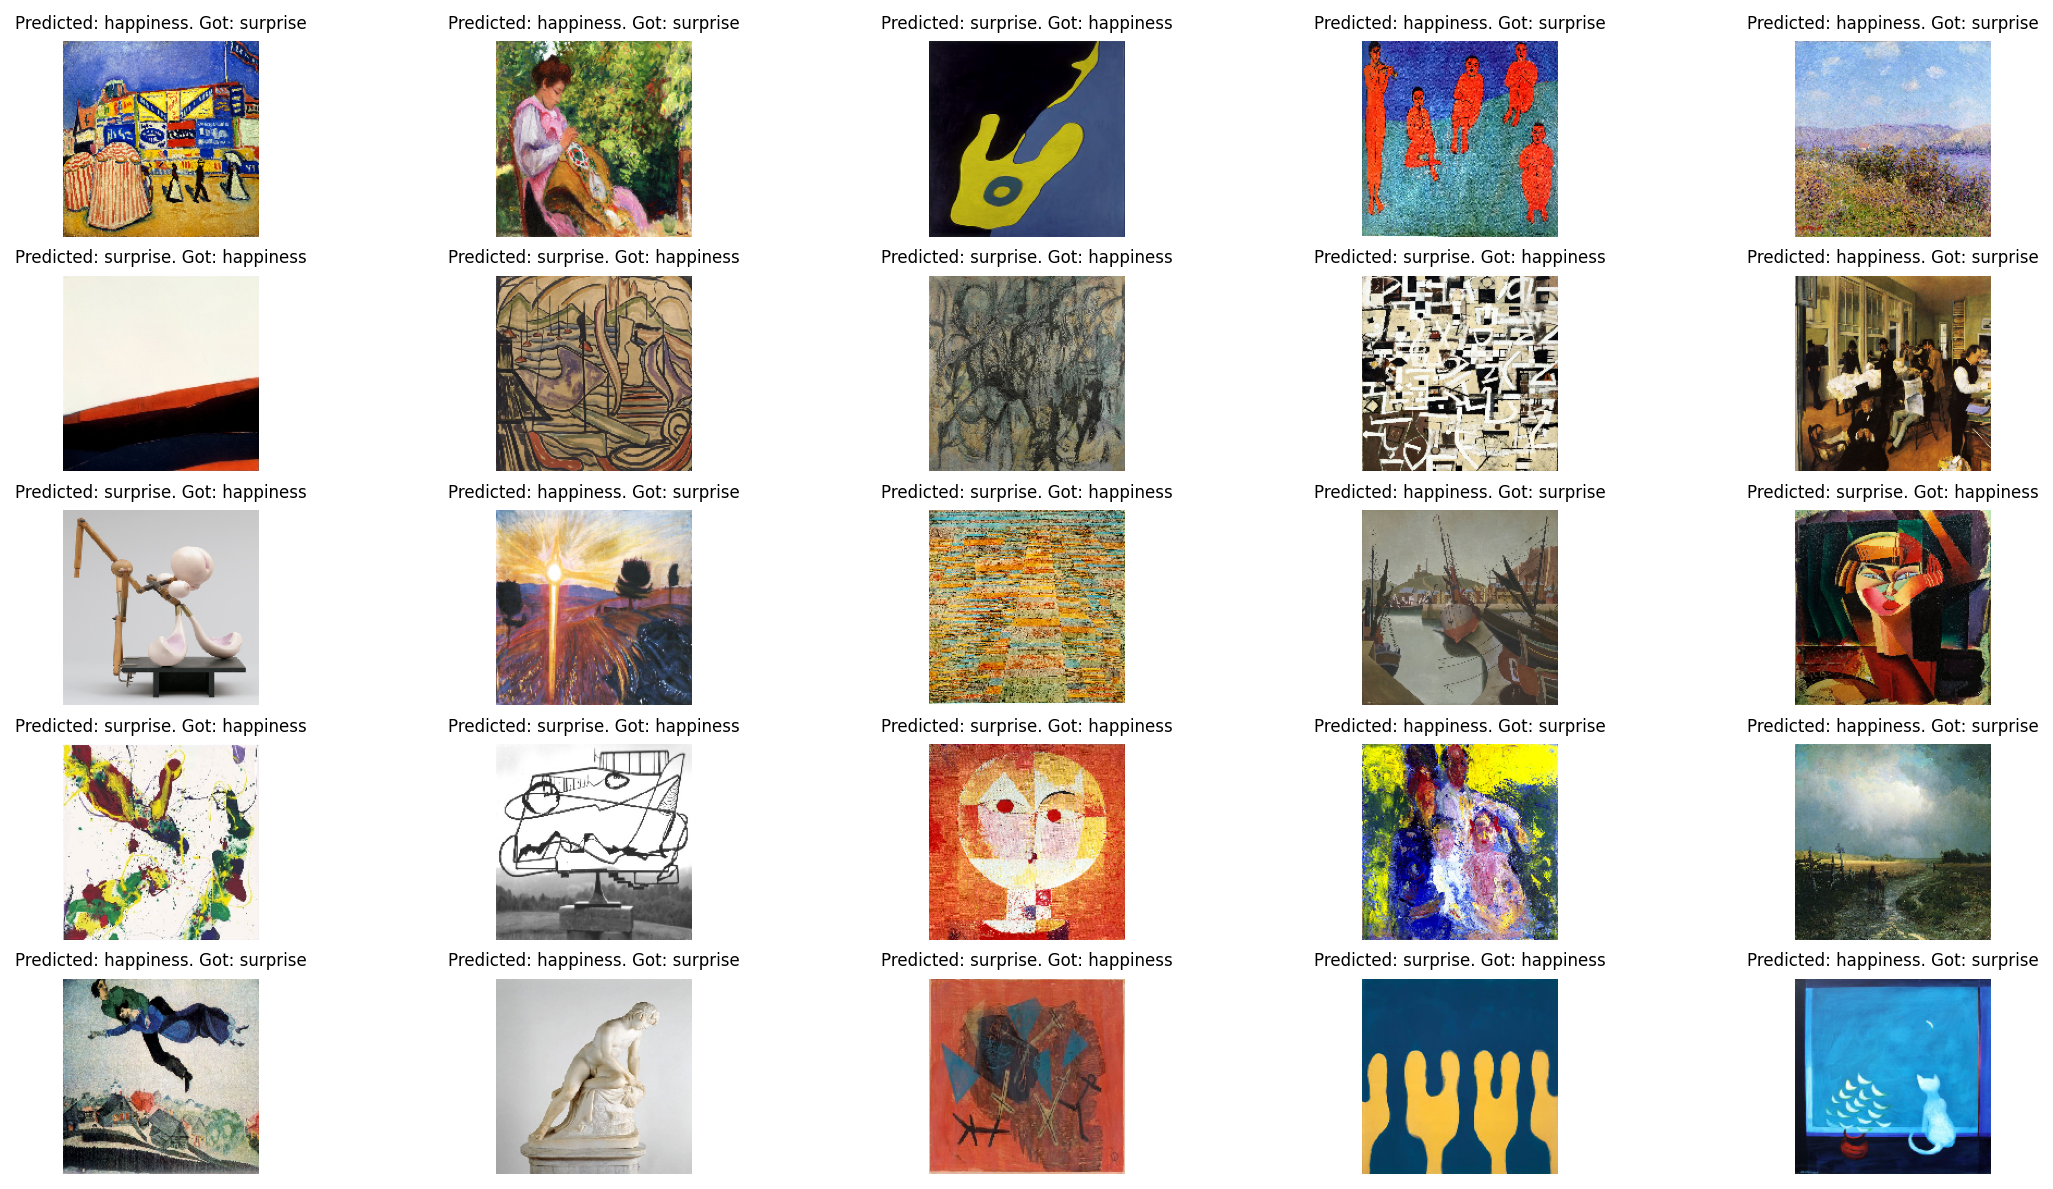

In [ ]:
plt.figure(figsize=(18, 10), dpi=150)
for i in range(25): 
  ax = plt.subplot(5, 5, i + 1)
  img = load_img(wrong_predictions.iloc[i, 1], target_size=(img_height, img_width))
  plt.imshow(img)
  plt.title('Predicted: {0}. Got: {1}'.format(wrong_predictions.iloc[i, 2], wrong_predictions.iloc[i, 3]), fontsize = 8)
  plt.axis("off")
